# TensorFlow中层API：Datasets+TFRecord的数据导入
ref:https://zhuanlan.zhihu.com/p/33223782

## 为什么用TFRecord？
在数据集较小时，我们会把数据全部加载到内存里方便快速导入，但当数据量超过内存大小时，就只能放在硬盘上来一点点读取，这时就不得不考虑数据的移动、读取、处理等速度。使用TFRecord就是为了提速和节约空间的。

### 数据存储

#### 1. 常用存储
输入$x_i$ 和 标签$y_i$是分开存储，若有100个样本，所有的输入存储成一个  $100\times5$ 的numpy矩阵；所有的输出则是 $100\times1$ 。

#### 2. TFRecord存储
TFRecord是以字典的方式一次写一个样本，字典的keys可以不以输入和标签，而以不同的特征（如学历，年龄，职业，收入）区分，在随后的读取中再选择哪些特征形成输入，哪些形成标签。这样的好处是，后续可以根据需要只挑选特定的特征；也可以方便应对例如多任务学习这样有多个输入和标签的机器学习任务。

注：一般而言，单数的feature是一个维度，即标量。所有的features组成representation。但在 TFRecord的存储中，字典中feature的value可以不是标量。如：key为学历的value就可以是：[初中，高中，大学]，3个features所形成的向量。亦可是任何维度的张量。

### 实现
#### 一、生成数据
除了标量和向量外，feature有时会是矩阵（如段落），有时会还会是三维张量（如图片）。

所以这里展示如何写入三个样本，每个样本有四个feature，分别是标量，向量，矩阵，三维张量（图片）。

In [1]:
import tensorflow as tf
# 为显示图片
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
%pylab inline
# 为数据操作
import pandas as pd
import numpy as np

Populating the interactive namespace from numpy and matplotlib



标量
type:int64
shape: ()
样本0
1
样本1
2
样本2
3

向量
type:float32
shape: (3,)
样本0
[0.1 0.1 0.1]
样本1
[0.2 0.2 0.2]
样本2
[0.3 0.3 0.3]

矩阵
type:float32
shape: (2, 3)
样本0
[[0.1 0.1 0.1]
 [0.1 0.1 0.1]]
样本1
[[0.2 0.2 0.2]
 [0.2 0.2 0.2]]
样本2
[[0.3 0.3 0.3]
 [0.3 0.3 0.3]]

张量
type:uint8
shape: (844, 844, 3)


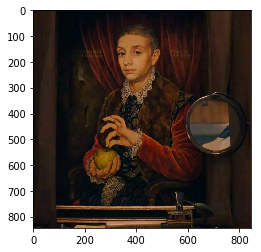

In [2]:
# 生成数据
# 精度3位
np.set_printoptions(precision=3)
# 用于显示数据
def display(alist, show = True):
    print('type:%s\nshape: %s' %(alist[0].dtype,alist[0].shape))
    if show:
        for i in range(3):
            print('样本%s\n%s' %(i,alist[i]))

scalars = np.array([1,2,3],dtype=int64)
print('\n标量')
display(scalars)

vectors = np.array([[0.1,0.1,0.1],
                    [0.2,0.2,0.2],
                    [0.3,0.3,0.3]],dtype=float32)
print('\n向量')
display(vectors)

matrices = np.array([np.array((vectors[0],vectors[0])),
                    np.array((vectors[1],vectors[1])),
                    np.array((vectors[2],vectors[2]))],dtype=float32)
print('\n矩阵')
display(matrices)

# shape of image：(806,806,3)
img=mpimg.imread('20181229133402.jpg') # 我的头像
tensors = np.array([img,img,img])
# show image
print('\n张量')
display(tensors, show = False)
plt.imshow(img)

#### 二、写入TFRecord
##### 1. 打开TFRecord file

In [3]:
writer = tf.python_io.TFRecordWriter('%s.tfrecord' %'test2')

##### 2. 创建样本写入字典
这里准备一个样本一个样本的写入TFRecord file中。

先把每个样本中所有feature的信息和值存到字典中，key为feature名，value为feature值。

feature值需要转变成tensorflow指定的feature类型中的一个：
- int64：tf.train.Feature(int64_list = tf.train.Int64List(value=输入))
- float32：tf.train.Feature(float_list = tf.train.FloatList(value=输入))
- string：tf.train.Feature(bytes_list=tf.train.BytesList(value=输入))

注：输入必须是list(向量)

#### 如何处理类型是张量的feature
tensorflow feature类型只接受list数据，但如果数据类型是矩阵或者张量该如何处理？

两种方式：
- 转成list类型：将张量flatten成list(也就是向量)，再用写入list的方式写入。
- 转成string类型：将张量用.tostring()转换成string类型，再用tf.train.Feature(bytes_list=tf.train.BytesList(value=[input.tostring()]))来存储。
- 形状信息：不管那种方式都会使数据丢失形状信息，所以在向该样本中写入feature时应该额外加入shape信息作为额外feature。shape信息是int类型，这里我是用原feature名字+'_shape'来指定shape信息的feature名。


In [4]:
# 这里我们将会写3个样本，每个样本里有4个feature：标量，向量，矩阵，张量
for i in range(3):
    # 创建字典
    features={}
    # 写入标量，类型Int64，由于是标量，所以"value=[scalars[i]]" 变成list
    features['scalar'] = tf.train.Feature(int64_list=tf.train.Int64List(value=[scalars[i]]))
    
    # 写入向量，类型float，本身就是list，所以"value=vectors[i]"没有中括号
    features['vector'] = tf.train.Feature(float_list = tf.train.FloatList(value=vectors[i]))
    
    # 写入矩阵，类型float，本身是矩阵，一种方法是将矩阵flatten成list
    features['matrix'] = tf.train.Feature(float_list = tf.train.FloatList(value=matrices[i].reshape(-1)))
    # 然而矩阵的形状信息(2,3)会丢失，需要存储形状信息，随后可转回原形状
    features['matrix_shape'] = tf.train.Feature(int64_list = tf.train.Int64List(value=matrices[i].shape))
    # 写入张量，类型float，本身是三维张量，另一种方法是转变成字符类型存储，随后再转回原类型
    features['tensor'] = tf.train.Feature(bytes_list=tf.train.BytesList(value=[tensors[i].tostring()]))
    # 存储丢失的形状信息(806,806,3)
    features['tensor_shape'] = tf.train.Feature(int64_list = tf.train.Int64List(value=tensors[i].shape))
    # 将存有所有feature的字典送入tf.train.Features中
    tf_features = tf.train.Features(feature= features)
    # 再将其变成一个样本example
    tf_example = tf.train.Example(features = tf_features)
    # 序列化该样本
    tf_serialized = tf_example.SerializeToString()
    # 写入一个序列化的样本
    writer.write(tf_serialized)
    # 由于上面有循环3次，所以到此我们已经写了3个样本
# 关闭文件    
writer.close()

##### 3. 转成tf_features

In [5]:
    # 将存有所有feature的字典送入tf.train.Features中
    tf_features = tf.train.Features(feature= features)

##### 4. 转成tf_example

In [6]:
    # 再将其变成一个样本example
    tf_example = tf.train.Example(features = tf_features)

##### 5. 序列化样本

In [7]:
    # 序列化该样本
    tf_serialized = tf_example.SerializeToString()

##### 6. 写入样本

In [8]:
    # 写入一个序列化的样本
    writer.write(tf_serialized)
    # 由于上面有循环3次，所以到此我们已经写了3个样本

FailedPreconditionError: Writer not initialized or previously closed

##### 7. 关闭TFRecord file

In [ ]:
# 关闭文件    
writer.close()

#### 三、使用Dataset

##### 1. 创建dataset
Dataset是你的数据集，包含了某次将要使用的所有样本，且所有样本的结构需相同（在tensorflow官网介绍中，样本example也被称作element）。样本需从source导入到dataset中，导入的方式有很多中。随后也可从已有的dataset中构建出新的dataset。

##### 1.1. 直接导入（非本文重点，随后不再提）

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices([1,2,3]) 
# 输入需是list，可以是numpy类型，可以是tf tensor类型，也可以直接输入

##### 1.2. 从TFRecord文件导入

In [ ]:
# 从多个tfrecord文件中导入数据到Dataset类 （这里用两个一样，同一个文件导入了两遍）
filenames = ["test2.tfrecord", "test.tfrecord"]
dataset = tf.data.TFRecordDataset(filenames)

#### 2. 操作dataset：

如优势中所提到的，我们希望对dataset中的所有样本进行统一的操作（batch，shuffle，padding等）。接下来就是对dataset的操作。

#### 2.1. dataset.map(func)
由于从tfrecord文件中导入的样本是刚才写入的tf_serialized序列化样本，所以我们需要对每一个样本进行解析。这里就用dataset.map(parse_function)来对dataset里的每个样本进行相同的解析操作。

注：dataset.map(输入)中的输入是一个函数。

#### 2.1.1. feature信息
解析基本就是写入时的逆过程，所以会需要写入时的信息，这里先列出刚才写入时，所有feature的各项信息。

注：用到了pandas，没有的请pip install pandas。

In [ ]:
data_info = pd.DataFrame({'name':['scalar','vector','matrix','matrix_shape','tensor','tensor_shape'],
                         'type':[scalars[0].dtype,vectors[0].dtype,matrices[0].dtype,tf.int64, tensors[0].dtype,tf.int64],
                         'shape':[scalars[0].shape,(3,),matrices[0].shape,(len(matrices[0].shape),),tensors[0].shape,(len(tensors[0].shape),)],
                         'isbyte':[False,False,True,False,False,False],
                         'length_type':['fixed','fixed','var','fixed','fixed','fixed']},
                         columns=['name','type','shape','isbyte','length_type','default'])
print(data_info)

有6个信息，name, type, shape, isbyte, length_type, default。前3个好懂，这里额外说明后3个：
- isbyte：是用于记录该feature是否字符化了。
- default：是当所读的样本中该feature值缺失用什么填补，这里并没有使用，所以全部都是np.NaN
- length_type：是指示读取向量的方式是否定长，之后详细说明。
注：这里的信息都是在写入时数据的原始信息。但是为了展示某些特性，这里做了改动：
- 把vector的shape从(3,)改动成了(1,3)
- 把matrix的length_type改成了var（不定长）


#### 2.1.2. 创建解析函数
接下就创建parse function。

In [ ]:
def parse_function(example_proto):
    # 只接受一个输入：example_proto，也就是序列化后的样本tf_serialized

#### Step 1. 创建样本解析字典
该字典存放着所有feature的解析方式，key为feature名，value为feature的解析方式。

解析方式有两种：
* 定长特征解析：tf.FixedLenFeature(shape, dtype, default_value)
 - shape：可当reshape来用，如vector的shape从(3,)改动成了(1,3)。
 - 注：如果写入的feature使用了.tostring() 其shape就是()
 - dtype：必须是tf.float32， tf.int64， tf.string中的一种。
 - default_value：feature值缺失时所指定的值。
* 不定长特征解析：tf.VarLenFeature(dtype)
 - 注：可以不明确指定shape，但得到的tensor是SparseTensor。

In [ ]:
    dics = {# 这里没用default_value，随后的都是None
            'scalar': tf.FixedLenFeature(shape=(), dtype=tf.int64, default_value=None), 
             
            # vector的shape刻意从原本的(3,)指定成(1,3)
            'vector': tf.FixedLenFeature(shape=(1,3), dtype=tf.float32), 
            
            # 使用 VarLenFeature来解析
            'matrix': tf.VarLenFeature(dtype=dtype('float32')), 
            'matrix_shape': tf.FixedLenFeature(shape=(2,), dtype=tf.int64), 
            
            # tensor在写入时 使用了toString()，shape是()
            # 但这里的type不是tensor的原type，而是字符化后所用的tf.string，随后再回转成原tf.uint8类型
            'tensor': tf.FixedLenFeature(shape=(), dtype=tf.string), 
            'tensor_shape': tf.FixedLenFeature(shape=(3,), dtype=tf.int64)}

#### Step 2. 解析样本
把序列化样本和解析字典送入函数里得到解析的样本

In [ ]:
    parsed_example = tf.parse_single_example(example_proto, dics)

#### Step 3. 转变特征
得到的parsed_example也是一个字典，其中每个key是对应feature的名字，value是相应的feature解析值。如果使用了下面两种情况，则还需要对这些值进行转变。其他情况则不用。

- string类型：tf.decode_raw(parsed_feature, type) 来解码
 * 注：这里type必须要和当初.tostring()化前的一致。如tensor转变前是tf.uint8，这里就需是tf.uint8；转变前是tf.float32，则tf.float32
- VarLen解析：由于得到的是SparseTensor，所以视情况需要用tf.sparse_tensor_to_dense(SparseTensor)来转变成DenseTensor


In [ ]:
# 解码字符
    parsed_example['tensor'] = tf.decode_raw(parsed_example['tensor'], tf.uint8)
    # 稀疏表示 转为 密集表示
    parsed_example['matrix'] = tf.sparse_tensor_to_dense(parsed_example['matrix'])

#### Step 4. 改变形状
到此为止得到的特征都是向量，需要根据之前存储的shape信息对每个feature进行reshape。

In [ ]:
# 转变matrix形状
    parsed_example['matrix'] = tf.reshape(parsed_example['matrix'], parsed_example['matrix_shape'])
    
    # 转变tensor形状
    parsed_example['tensor'] = tf.reshape(parsed_example['tensor'], parsed_example['tensor_shape'])

#### Step 5. 返回样本
现在样本中的所有feature都被正确设定了。可以根据需求将不同的feature进行拆分合并等处理，得到想要的输入 x 和标签 y ，最终在parse_function末尾返回。这里为了展示，我直接返回存有4个特征的字典。

In [ ]:
# 返回所有feature
    return parsed_example

上面拆解了解析函数，下面把函数定义写在一起，方便执行

In [ ]:
# 上面拆解了解析函数，下面把函数定义写在一起，方便执行
def parse_function(example_proto):
    # 只接受一个输入：example_proto，也就是序列化后的样本tf_serialized
    dics = {# 这里没用default_value，随后的都是None
            'scalar': tf.FixedLenFeature(shape=(), dtype=tf.int64, default_value=None), 
             
            # vector的shape刻意从原本的(3,)指定成(1,3)
            'vector': tf.FixedLenFeature(shape=(1,3), dtype=tf.float32), 
            
            # 使用 VarLenFeature来解析
            'matrix': tf.VarLenFeature(dtype=dtype('float32')), 
            'matrix_shape': tf.FixedLenFeature(shape=(2,), dtype=tf.int64), 
            
            # tensor在写入时 使用了toString()，shape是()
            # 但这里的type不是tensor的原type，而是字符化后所用的tf.string，随后再回转成原tf.uint8类型
            'tensor': tf.FixedLenFeature(shape=(), dtype=tf.string), 
            'tensor_shape': tf.FixedLenFeature(shape=(3,), dtype=tf.int64)}
    
    parsed_example = tf.parse_single_example(example_proto, dics)
    
    # 解码字符
    parsed_example['tensor'] = tf.decode_raw(parsed_example['tensor'], tf.uint8)
    # 稀疏表示 转为 密集表示
    parsed_example['matrix'] = tf.sparse_tensor_to_dense(parsed_example['matrix'])
    
    # 转变matrix形状
    parsed_example['matrix'] = tf.reshape(parsed_example['matrix'], parsed_example['matrix_shape'])
    # 转变tensor形状
    parsed_example['tensor'] = tf.reshape(parsed_example['tensor'], parsed_example['tensor_shape'])
    
    # 返回所有feature
    return parsed_example

#### 2.1.3. 执行解析函数
创建好解析函数后，将创建的parse_function送入dataset.map()得到新的数据集

In [ ]:
new_dataset = dataset.map(parse_function)

In [ ]:
new_dataset

#### 2.2. 创建迭代器

有了解析过的数据集后，接下来就是获取当中的样本。


In [ ]:
# 创建获取数据集中样本的迭代器
iterator = new_dataset.make_one_shot_iterator()

#### 2.3. 获取样本



In [ ]:
# 获得下一个样本
next_element = iterator.get_next()
# 创建Session
sess = tf.InteractiveSession()

# 获取
i = 1
while True:
    # 不断的获得下一个样本
    try:
        # 获得的值直接属于graph的一部分，所以不再需要用feed_dict来喂
        scalar,vector,matrix,tensor = sess.run([next_element['scalar'],
                                                next_element['vector'],
                                                next_element['matrix'],
                                                next_element['tensor']])
    # 如果遍历完了数据集，则返回错误
    except tf.errors.OutOfRangeError:
        print("End of dataset")
        break
    else:
        # 显示每个样本中的所有feature的信息，只显示scalar的值
        print('==============example %s ==============' %i)
        print('scalar: value: %s | shape: %s | type: %s' %(scalar, scalar.shape, scalar.dtype))
        print('vector shape: %s | type: %s' %(vector.shape, vector.dtype))
        print('matrix shape: %s | type: %s' %(matrix.shape, matrix.dtype))
        print('tensor shape: %s | type: %s' %(tensor.shape, tensor.dtype))
    i+=1
plt.imshow(tensor)

#### 2.4. Shuffle

可以轻松使用.shuffle(buffer_size= ) 来打乱顺序。buffer_size设置成一个大于你数据集中样本数量的值来确保其充分打乱。
注：对于数据集特别巨大的情况，请参考[YJango：tensorflow中读取大规模tfrecord如何充分shuffle？]()

In [12]:
shuffle_dataset = new_dataset.shuffle(buffer_size=10000)
iterator = shuffle_dataset.make_one_shot_iterator()
next_element = iterator.get_next()

i = 1
while True:
    try:
        scalar = sess.run(next_element['scalar'])
    except tf.errors.OutOfRangeError:
        print("End of dataset")
        break
    else:
        print('example %s | scalar: value: %s' %(i,scalar))
    i+=1

example 1 | scalar: value: 2
example 2 | scalar: value: 1
example 3 | scalar: value: 3
example 4 | scalar: value: 1
example 5 | scalar: value: 2
example 6 | scalar: value: 3
End of dataset


### 2.5. Batch
再从乱序后的数据集上进行batch。

In [13]:
batch_dataset = shuffle_dataset.batch(4)
iterator = batch_dataset.make_one_shot_iterator()
next_element = iterator.get_next()

i = 1
while True:
    # 不断的获得下一个样本
    try:
        scalar = sess.run(next_element['scalar'])
    except tf.errors.OutOfRangeError:
        print("End of dataset")
        break
    else:
        print('example %s | scalar: value: %s' %(i,scalar))
    i+=1

example 1 | scalar: value: [2 1 1 3]
example 2 | scalar: value: [2 3]
End of dataset


### 2.6. Batch_padding
也可以在每个batch内进行padding

padded_shapes指定了内部数据是如何pad的。

- rank数要与元数据对应
- rank中的任何一维被设定成None或-1时都表示将pad到该batch下的最大长度


In [14]:
batch_padding_dataset = new_dataset.padded_batch(4, 
                        padded_shapes={'scalar': [],
                                       'vector': [-1,5],
                                       'matrix': [None,None],
                                       'matrix_shape': [None],
                                       'tensor': [None,None,None],
                                       'tensor_shape': [None]})
iterator = batch_padding_dataset.make_one_shot_iterator()
next_element = iterator.get_next()

i = 1
while True:
    try:
        scalar,vector,matrix,tensor = sess.run([next_element['scalar'],
                                                next_element['vector'],
                                                next_element['matrix'],
                                                next_element['tensor']])
    except tf.errors.OutOfRangeError:
        print("End of dataset")
        break
    else:
        print('==============example %s ==============' %i)
        print('scalar: value: %s | shape: %s | type: %s' %(scalar, scalar.shape, scalar.dtype))
        print('padded vector value\n%s:\nvector shape: %s | type: %s' %(vector, vector.shape, vector.dtype))
        print('matrix shape: %s | type: %s' %(matrix.shape, matrix.dtype))
        print('tensor shape: %s | type: %s' %(tensor.shape, tensor.dtype))
    i+=1

==============example 1 ==============
scalar: value: [1 2 3 1] | shape: (4,) | type: int64
padded vector value
[[[0.1 0.1 0.1 0.  0. ]]

 [[0.2 0.2 0.2 0.  0. ]]

 [[0.3 0.3 0.3 0.  0. ]]

 [[0.1 0.1 0.1 0.  0. ]]]:
vector shape: (4, 1, 5) | type: float32
matrix shape: (4, 2, 3) | type: float32
tensor shape: (4, 844, 844, 3) | type: uint8
==============example 2 ==============
scalar: value: [2 3] | shape: (2,) | type: int64
padded vector value
[[[0.2 0.2 0.2 0.  0. ]]

 [[0.3 0.3 0.3 0.  0. ]]]:
vector shape: (2, 1, 5) | type: float32
matrix shape: (2, 2, 3) | type: float32
tensor shape: (2, 844, 844, 3) | type: uint8
End of dataset


### 2.7. Epoch
使用.repeat(num_epochs) 来指定要遍历几遍整个数据集

In [15]:
# num
num_epochs = 2
epoch_dataset = new_dataset.repeat(num_epochs)
iterator = epoch_dataset.make_one_shot_iterator()
next_element = iterator.get_next()

i = 1
while True:
    try:
        scalar = sess.run(next_element['scalar'])
    except tf.errors.OutOfRangeError:
        print("End of dataset")
        break
    else:
        print('example %s | scalar: value: %s' %(i,scalar))
    i+=1

example 1 | scalar: value: 1
example 2 | scalar: value: 2
example 3 | scalar: value: 3
example 4 | scalar: value: 1
example 5 | scalar: value: 2
example 6 | scalar: value: 3
example 7 | scalar: value: 1
example 8 | scalar: value: 2
example 9 | scalar: value: 3
example 10 | scalar: value: 1
example 11 | scalar: value: 2
example 12 | scalar: value: 3
End of dataset


## only image

In [3]:
img=mpimg.imread('20181229133402.jpg') # 我的头像
tensors = np.array([img,img,img])

In [7]:
tensors.shape

(3, 844, 844, 3)

In [6]:
import pickle
load_path = r'..\data\mnist\valid_mnist_c.pkl'
with open(load_path, 'rb') as in_f:
        data_dict = pickle.load(in_f)
        label = data_dict['label']
        img = data_dict['feature']

In [8]:
images = img

In [14]:
images.shape[0]

5000

In [12]:
writer = tf.python_io.TFRecordWriter('%s.tfrecord' %'test3')

In [16]:
for i in range(images.shape[0]):
    # 创建字典
    features={}
    # 写入张量，类型float，本身是三维张量，另一种方法是转变成字符类型存储，随后再转回原类型
    features['image'] = tf.train.Feature(bytes_list=tf.train.BytesList(value=[images[i].tostring()]))
    # 存储丢失的形状信息(806,806,3)
    features['image_shape'] = tf.train.Feature(int64_list = tf.train.Int64List(value=images[i].shape))
    # 将存有所有feature的字典送入tf.train.Features中
    tf_features = tf.train.Features(feature= features)
    # 再将其变成一个样本example
    tf_example = tf.train.Example(features = tf_features)
    # 序列化该样本
    tf_serialized = tf_example.SerializeToString()
    # 写入一个序列化的样本
    writer.write(tf_serialized)
    # 由于上面有循环3次，所以到此我们已经写了3个样本
# 关闭文件    
writer.close()

In [17]:
dataset = tf.data.TFRecordDataset('%s.tfrecord' %'test3')

In [18]:
def parse_function(example_proto):
    # 只接受一个输入：example_proto，也就是序列化后的样本tf_serialized
    dics = {
            # tensor在写入时 使用了toString()，shape是()
            # 但这里的type不是tensor的原type，而是字符化后所用的tf.string，随后再回转成原tf.uint8类型
            'image': tf.FixedLenFeature(shape=(), dtype=tf.string), 
            'image_shape': tf.FixedLenFeature(shape=(3,), dtype=tf.int64)}
    
    parsed_example = tf.parse_single_example(example_proto, dics)
    
    # 解码字符
    parsed_example['image'] = tf.decode_raw(parsed_example['image'], tf.float32)
    
    # 转变tensor形状
    parsed_example['image'] = tf.reshape(parsed_example['image'], parsed_example['image_shape'])
    
    # 返回所有feature
    return parsed_example

In [19]:
new_dataset = dataset.map(parse_function)

In [20]:
new_dataset

<MapDataset shapes: {image: (?, ?, ?), image_shape: (3,)}, types: {image: tf.float32, image_shape: tf.int64}>

In [21]:
iterator = new_dataset.make_one_shot_iterator()

In [24]:
next_element = iterator.get_next()
# 创建Session
sess = tf.InteractiveSession()
i = 1
while True:
    # 不断的获得下一个样本
    try:
        # 获得的值直接属于graph的一部分，所以不再需要用feed_dict来喂
        image = sess.run([next_element['image']])
    # 如果遍历完了数据集，则返回错误
    except tf.errors.OutOfRangeError:
        print("End of dataset")
        break

InvalidArgumentError: Input to reshape is a tensor with 784 values, but the requested shape has 2137008
	 [[{{node Reshape}} = Reshape[T=DT_FLOAT, Tshape=DT_INT64](DecodeRaw, ParseSingleExample/ParseSingleExample:1)]]
	 [[node IteratorGetNext_2 (defined at <ipython-input-24-4d164b9edd9b>:1)  = IteratorGetNext[output_shapes=[[?,?,?], [3]], output_types=[DT_FLOAT, DT_INT64], _device="/job:localhost/replica:0/task:0/device:CPU:0"](OneShotIterator)]]

In [25]:
2137008/784

2725.7755102040815